<center> <h1>IST 664 Final Project</h1>
<h2>Professor Nancy McCracken
    <br>
Syracuse University
    <br>
By Mike Kane</h2>

</center>
<br>
<br>
<br>
<center><h2> Toxic Comment Classification Using Bidirectional Neural Networks </center></h2>





In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from subprocess import check_output
import sys
import logging
import os
import re
import csv
import codecs
import gensim
from gensim.models.word2vec import Word2Vec
import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk 
from nltk import word_tokenize
from nltk.text import TextCollection
from nltk.corpus import stopwords
import string


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
base_path = 'data/'
train_path = '{}train.csv'.format(base_path)
test_path = '{}test.csv'.format(base_path)

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
labels_train_df = train_df.drop(['id', 'comment_text'], axis=1, inplace=False)

In [13]:
labels_train_df.sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

# Restructuring As a Binary Classification Problem

The data set is currently set up as a multi-categorical problem to detect 6 different kinds of toxic comments. This function rehapes the data into a binary classification problem by merging all target columns into a single column.

In [21]:
train_df['target'] = train_df.drop(['id', 'comment_text'], axis=1, inplace=False).any(axis=1)
train_df['target'] = train_df['target'].map({True: 1, False: 0})
train_df['target'].unique()

array([0, 1], dtype=int64)

In [22]:
train_df[train_df.target == 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1


In [23]:
cols_to_drop = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
binarized_labels_df = train_df.drop(cols_to_drop, axis=1, inplace=False)
binarized_labels_df.head()

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


# of Positive Examples: 16225
# of Negative Examples: 143346


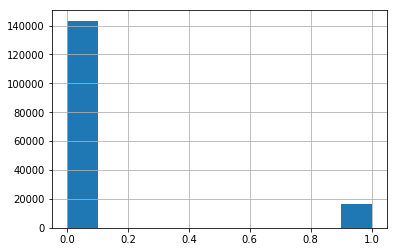

In [24]:
print("# of Positive Examples: {}".format(binarized_labels_df.target.sum()))
print("# of Negative Examples: {}".format(len(binarized_labels_df) - binarized_labels_df.target.sum()))
binarized_labels_df.target.hist()

# Reduce Sample Size

As is, models run out of memory when training on the dataset. We'll train on a sample of the data to alleviate this error and reduce run times. Since there is class imbalance, we'll want to stratify our sampling. 

In [12]:
# Separate positive and negative examples in training
pos_train_df = binarized_labels_df[binarized_labels_df['target'] == 1]
neg_train_df = binarized_labels_df[binarized_labels_df['target'] == 0]

In [27]:
# Get number of positive examples
type(len(pos_train_df))

int

In [34]:
# Generate indices for random sampling of negative training examples
neg_index = list(np.random.randint(0, high=len(neg_train_df)-1, size=len(pos_train_df)))

In [44]:
# Downsample Data by slicing the DataFrame using the random integers generated as indices
neg_samples_df = pd.DataFrame(neg_train_df.iloc[neg_index], columns=neg_train_df.columns)
neg_samples_df.head()

,comment_text,target
142997,"193.1.217.20, You nailed it. Thanks for what y...",0
132144,"""\n\nUnblock: South Korean population update. ...",0
97091,Hello\nI just wanted to let you know how you c...,0
109396,definition? \nso does stephen mean anything? s...,0
35417,Afghanistan\n\nI just saw Matt Sanchez on the ...,0


In [46]:
len(neg_samples_df)

16225

In [67]:
train_df = pd.concat([neg_samples_df, pos_train_df])
print(len(train_df))
train_df.index = range(0, len(train_df))
train_df.head()

32450


,comment_text,target
0,"193.1.217.20, You nailed it. Thanks for what y...",0
1,"""\n\nUnblock: South Korean population update. ...",0
2,Hello\nI just wanted to let you know how you c...,0
3,definition? \nso does stephen mean anything? s...,0
4,Afghanistan\n\nI just saw Matt Sanchez on the ...,0



### Step 1: Tokenize All Comments

In [84]:
def cleanup_comment(c):
    stopset = set(stopwords.words('english') + list(string.punctuation) + ["''", '""', '``'])
    tokens = nltk.word_tokenize(c)
    stopwords_removed = [t.lower() for t in tokens if t not in stopset]
    return stopwords_removed

In [85]:
train_df['tokenized_comments'] = train_df['comment_text'].map(cleanup_comment)

In [86]:
train_df.tokenized_comments[0]

['193.1.217.20', 'you', 'nailed', 'thanks', 'wrote']

### Step 2: Store Labels and Data Separately

In [87]:
data = train_df.tokenized_comments
labels = train_df.target

### Step 3: Get Total Vocabulary

To get the total vocabulary, we'll combine everything into a set. During this step, we'll also concatenate all comments and use NLTK.FreqDist() to retrieve the top 25000 most common words. 


In [89]:
total_vocab = set()
for comment in data:
    total_vocab.update(comment)
len(total_vocab)

78709

Once stop words and punctuation have been removed, there are 78,709 words in this data set. 

Now, we'll create a frequency distribution and get the top 2000 most common words, for testing purposes. 

In [90]:
all_comments_combined = ""
for comment in data:
    for word in comment:
        all_comments_combined += word + " "

In [96]:
comments_freq_dist = nltk.FreqDist(cleanup_comment(all_comments_combined))

In [143]:
most_common_words = comments_freq_dist.most_common(2000)

### Step 4: Vectorization

We'll start by using the Bag of Words/Unigram baseline used in labs from class. This creates a vector of booleans, where each element in vector corresponds to one of the 2000 unique words in the `most_common_words` frequency distribution we created above. If the word is present in the comment, then the element corresponding to that word will be `True`, otherwise `False`. These will be extremely sparse vectors. 

In [144]:
def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

In [145]:
featuresets = [document_features(comment, most_common_words) for comment in data]

In [146]:
featuresets = pd.DataFrame(featuresets)

### Step 5: Creating Training and Testing Sets

Here, we would normally split our data into training and testing sets. However, since we're using cross validation, we don't actually need to do this. The `cross_val_score` function from sklearn will handle this for us. 

In [129]:
# X_train, X_test, y_train, y_test = train_test_split(featuresets, labels, test_size=0.25)

### Step 6: Train Classifiers and Check Performance

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

base_rf = RandomForestClassifier(n_estimators=100)
base_xgboost = XGBClassifier(jobs=-1)
base_bernoulli_nb = BernoulliNB()


In [149]:
# Cross Validation Score for Random Forest
cross_val_score(base_rf, featuresets, labels, cv=3)

array([0.5, 0.5, 0.5])

In [150]:
cross_val_score(base_xgboost, featuresets, labels, cv=3)

array([0.5, 0.5, 0.5])

In [148]:
cross_val_score(base_bernoulli_nb, featuresets, labels, cv=3)

array([0.5, 0.5, 0.5])

In [151]:
to_write = featuresets
to_write['labels'] = labels
to_write.to_csv("top_10000_words.csv", index=False)

None of the models did better than random chance when the vocab size was reduced to the 2000 most common words. Each scored a mean Cross-Validation accuracy of 50%. 

I experimented with different vocabulary sizes, and the results were as follows.

|       Vocab Size      | Random Forest  | XGBoost | Bernoulli Naive Bayes |
|:-----------:|:--------------:|:-------:|:---------------------:|
|  2000 Words |       0.5      |   0.5   |          0.5          |
| 5000 words |         0.5       |   0.5      |     0.5                  |
| 10000 words |       Memory Error         |   Memory Error      |    Memory Error                   |

When I tried creating a version of the dataset with the top 10000 words, I got a memory error when trying to create the dataset. Upon inspection, a CSV of the transformed dataset (and corresponding labels) clocks in at just under a gigabyte, so it makes sense that the 10,000 word version wouldn't fit in memory. In it's current naive format, this is too big, but this dataset's dimensionality shouldnt be a problem once we use one of the major libraries. As is, the dataset wastes a lot of space that can be optimized once we take into account that these are extremely sparse vectors. 


## Part 2: Using Word2Vec Vectorization

Since we had no success with the current wa

# Deep Learning Section

This task is best suited for a Deep Learning approach. We have enough data, and the need for context suggests an embedding layer will be very helpful for capturing context and nuance. Furthermore, the ability of LSTMs to learn to remember what's important (and forget what isn't!) will likely be very helpful in helping deal with the complexities of the language in the comments. 

### Preprocessing Steps

To set up the data for use in our model, we'll make use of the `preprocessing` module found within `keras`. Specifically, we'll use the following packages:

**_Text_**: The `text` module provides access to keras's own _Tokenizer_ class. We'll use this tokenizer to fit on the dataset, and then use it to convert the text to sequences, which are the input type we'll need to use to feed our data into embedding and LSTM layers. 

**_sequence_**: Once we've created the sequences, we'll then use the `sequence` class to pad all sequences, so that they are all the same uniform shape. 

In [15]:
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [16]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train = train.sample(frac=1)

In [17]:
list_sentences_train = train["comment_text"].fillna("CVxTz").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("CVxTz").values

In [18]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=100)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=100)

# Model Architecture

For the Deep Learning model, we'll use a **_Bidrectional LSTM_**, with a **_Multi Layer Perceptron_** tacked on to the end to handle the actual classification. The output of the model is a vector with 6 elements, all bounded between 0 and 1. Each element corresponds to a different kind of toxic comment (in order, "toxic", "severe_toxic", "obscene", "threat", "insult", and "identity_hate"). Although this is a multiclass classification problem, the classes are **_not mutually exclusive_**, meaning that a comment can be multiple kinds of toxic classes at the same time. 


The architecture we'll begin with is as follows:

1. An **_Embedding Layer_** that will act as a Word2Vec model that creates word embeddings based on the text docudments fed into the model.  This will allow the model to vectorize the text in an advanced way that captures both contextual references, as well as common noun phrases (e.g. treating "New York" as a single phrase, instead of individual "New" and "York" tokens).  
<br>  
2. A **_Bidrectional Layer_** containing an **_LSTM_** layer consisting of 50 cells. This bidirectional layer handles all the complexity of bidirectional learning. Let's assume that the network is trying to classify a sentence containing 10 words, with we can label each word $X_t$ sequentially as $X_0, X_1, ... X_9$, respectively. Half of the bidirectional layer will work as a traditional feed-forward RNN, starting at $X_0$, making a prediction, and then passing along it's internal state and its prediction along to the next time step, along with word $X_1$, and so on until it reaches the end of the sequence. The other half of the model does the same things, but starts at the end and works backwards towards the beginning--$X_9$, then $X_8$, and so on.    
<br>     

3. In both make predictions at the same time, and then we use a **_Global MaxPooling_** operation to pool each time step and take the strongest prediction at each time step, regardless of whether it came from the front-to-back or back-to-front portion of the Bidirectional LSTM.  
<br>  
   
4. We then tack on a **_Dropout Layer_** to regularize our network and discourage overfitting, with each neuron's "keep chance" at 90%.   
<br>    
   
5. Next, we have a Dense layer to learn feature representations based on what was returned from the Bidirectional LSTM layer. Everything between the first and last Dense layers can basically be interpreted as a vanilla feed-forward neural network--the only difference being that the first hidden Dense layer is learning from the sequences returned by the Bidrectional LSTM layer, rather than a traditional input layer. As with the previous layer, another **_Dropout Layer_** is used for regularization purposes.   
<br>    
    
6. The final layer of the network is a fully-connected layer with 6 neurons, where each corresponds to one of the 6 kinds of toxic classes the model is trying to predict. The choice of activation function here is a bit unique for a multiclass classification problem. Typically, multiclass classification problems utilize a softmax activation function, which splits total likelihood of 1. across each element in the vector (with the element with the highest value being the class predicted by the model). However, this classification problem is unique in that any given example can multiple kinds of target classes at the same time. For example, a toxic comment that is both "obscene", 'threatening' and 'severe_toxic'. Because of this, each of the neurons uses a sigmoid activation function, allowing the model to act as 6 different binary classifiers at the same time--1 for each of the target classes. 
<br>  

## Other Notes

### Embedding Size Parameter
The embedding size is heuristically determined (meaning it's a magic number I found recommended online for this problem). 

### Callbacks

Since the model is **_extremely slow_** to train, I've utilized two callbacks:

**_Weight Checkpoints:_**  A checkpoint callback for recording the weights for the model's best performance at any given time, so that we can always reload them easily and save on training time. 

**_Early Stopping Checkpoint:_** A checkpoint that utilizes early stopping if model performance stagnates, or begins to drop due to overfitting on the training set. 

### Compile-Time Parameters

I used the following compile-time parameters for this model:

**_Loss: Binary Crossentropy_**. As mentioned above, although the problem is multiclass in nature, the special case of overlapping classes means that we need to use _Binary Crossentropy_ as our loss function to compute the loss for each neuron in the output layer. The _sigmoid_ activation functions on the neurons in the output layer make this a dead giveaway (whereas if we had used a _softmax_ activation function, we'd want to make use of _Categorical Crossentropy_ instead).

**_Optimizer: adam_**. I elected to choose the _adam_ optimizer, which is short for **_Adaptive Moment Estimation_**. This was another heuristic choice, although it tends to be my go-to optimizer for models that take a long time to train, as it's currently considered the most advanced optimizer out there. The _adam_ optimizer is a combination of the _RMSProp_ optimizer (short for _Root Mean Square Propagation_) and _Nesterov Momentum_. 

In [19]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(15000, embedding_size)(input_)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='sigmoid')(x)

model = Model(inputs = input_, outputs=x)


In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

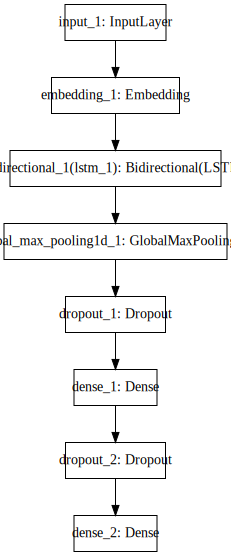

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [176]:
checkpoints_path = 'weights_base.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [179]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [181]:
callbacks = [checkpoint, early_stopping]

In [183]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1, callbacks=callbacks)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1341s 9ms/step - loss: 0.0639 - acc: 0.9790 - val_loss: 0.0485 - val_acc: 0.9825

Epoch 00001: val_loss improved from inf to 0.04850, saving model to weights_base.best.hdf5
Epoch 2/2
143613/143613 [==============================] - 1339s 9ms/step - loss: 0.0460 - acc: 0.9830 - val_loss: 0.0476 - val_acc: 0.9834

Epoch 00002: val_loss improved from 0.04850 to 0.04756, saving model to weights_base.best.hdf5


In [184]:
input_ = Input(shape=(100,))
x = Embedding(15000, embedding_size)(input_)
x = Bidirectional(LSTM(75, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(75, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='sigmoid')(x)

model = Model(inputs = input_, outputs=x)

In [185]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [186]:
checkpoints_path_2 = 'weights_base_iter2.best.hdf5'
checkpoint_2 = ModelCheckpoint(checkpoints_path_2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping_2 = EarlyStopping(monitor='val_loss', mode='min', patience=20)
callbacks_2 = [checkpoint_2, early_stopping_2]

In [187]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1, callbacks=callbacks_2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1377s 10ms/step - loss: 0.0667 - acc: 0.9781 - val_loss: 0.0516 - val_acc: 0.9814

Epoch 00001: val_loss improved from inf to 0.05156, saving model to weights_base_iter2.best.hdf5
Epoch 2/2
143613/143613 [==============================] - 1355s 9ms/step - loss: 0.0473 - acc: 0.9827 - val_loss: 0.0468 - val_acc: 0.9834

Epoch 00002: val_loss improved from 0.05156 to 0.04678, saving model to weights_base_iter2.best.hdf5


  # Conclusion
  
  The LSTM model was able to quite easily perform toxic comment classification. 